# FET445 – Veri Madenciliği  
## Depression Dataset – Model Improvement & Two-Stage Classification

Bu notebook, **Depression Dataset** üzerinde yapılan çalışmaları ve
model performansını artırmak amacıyla geliştirilen yöntemleri içermektedir.

Notebook üç ana bölümden oluşmaktadır:

1. **Orijinal Çalışma (Visa )**  
   - Temel ön işleme  
   - Özellik seçimi  
   - Boyut indirgeme  
   - Baz modeller  

2. **İyileştirme Aşaması (RandomForest + SMOTETomek)**  
   - Dengesiz veri problemi çözümü  
   - Threshold tuning  

3. **İki Aşamalı Sistem (Two-Stage System)**  
   - Stage 1: RandomForest (yüksek recall)  
   - Stage 2: XGBoost (daha güçlü nihai karar)


In [1]:
!pip install imbalanced-learn


In [2]:
!pip install xgboost


In [3]:
# ====== Core Libraries ======
import pandas as pd
import numpy as np

# ====== Sklearn ======
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

# ====== Models ======
from sklearn.ensemble import RandomForestClassifier

# ====== Imbalanced Learning ======
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# ====== Visualization ======
import matplotlib.pyplot as plt
import seaborn as sns

# ====== XGBoost (Stage 2) ======
from xgboost import XGBClassifier

pd.set_option("display.max_columns", 100)

print("✅ All libraries imported successfully")


✅ All libraries imported successfully


## Veri Yükleme ve Hedef Değişken

Bu çalışmada **Depression Dataset** kullanılmaktadır.  
Amaç, bireylerin geçmişte psikolojik bir rahatsızlık yaşayıp yaşamadığını
(`History of Mental Illness`) tahmin etmektir.

- Hedef değişken: `History of Mental Illness`
- Görev türü: İkili sınıflandırma (Binary Classification)


In [4]:
# Dataset path and target column
CSV_PATH = "depression_data.csv"
TARGET_COL = "History of Mental Illness"

# Load dataset
df = pd.read_csv(CSV_PATH)

# Map target to binary
df[TARGET_COL] = df[TARGET_COL].map({"No": 0, "Yes": 1})

# Drop non-informative column if exists
if "Name" in df.columns:
    df.drop(columns=["Name"], inplace=True)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (413768, 15)


,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,No,Yes,Yes
1,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,No,No,Yes
2,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,No,Yes,No
3,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,No,No,No
4,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,No,Yes,Yes


## Veri Setine Genel Bakış

Bu bölümde:
- Sütun tipleri,
- Eksik değer durumu,
- Hedef değişkenin dağılımı
incelenmektedir.


Column types:

Age                               int64
Marital Status                   object
Education Level                  object
Number of Children                int64
Smoking Status                   object
Physical Activity Level          object
Employment Status                object
Income                          float64
Alcohol Consumption              object
Dietary Habits                   object
Sleep Patterns                   object
History of Mental Illness         int64
History of Substance Abuse       object
Family History of Depression     object
Chronic Medical Conditions       object
dtype: object

Missing values per column:

Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sl

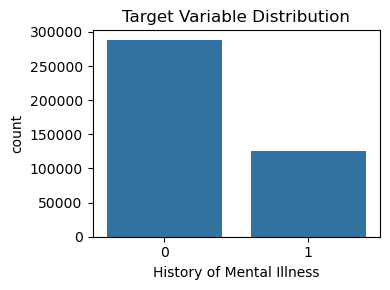

In [5]:
# Column types
print("Column types:\n")
print(df.dtypes)

# Missing values
print("\nMissing values per column:\n")
print(df.isna().sum())

# Target distribution
print("\nTarget distribution (count):")
print(df[TARGET_COL].value_counts())

print("\nTarget distribution (ratio):")
print(df[TARGET_COL].value_counts(normalize=True))

# Visualization
plt.figure(figsize=(4,3))
sns.countplot(x=TARGET_COL, data=df)
plt.title("Target Variable Distribution")
plt.tight_layout()
plt.show()


## Özellik ve Hedef Ayrımı

Bu adımda:
- Özellikler (`X`)
- Hedef değişken (`y`)
ayrılmaktadır.


In [6]:
# Feature-target split
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Detect numeric and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['Age', 'Number of Children', 'Income']
Categorical columns: ['Marital Status', 'Education Level', 'Smoking Status', 'Physical Activity Level', 'Employment Status', 'Alcohol Consumption', 'Dietary Habits', 'Sleep Patterns', 'History of Substance Abuse', 'Family History of Depression', 'Chronic Medical Conditions']


## Ön İşleme (Preprocessing Pipeline)

Tüm modeller için ortak ön işleme adımları:

- Sayısal sütunlar:
  - Median ile eksik değer doldurma
  - Min-Max ölçeklendirme
- Kategorik sütunlar:
  - En sık değer ile doldurma
  - One-Hot Encoding


In [7]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

print("✅ Preprocessing pipeline hazır")


✅ Preprocessing pipeline hazır


## Eğitim ve Test Kümesine Ayırma

Veri seti:
- %80 eğitim
- %20 test
olarak ayrılmaktadır.

Sınıf dağılımı korunmuştur (stratify).


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (331014, 14)
Test shape: (82754, 14)


## Model Değerlendirme Fonksiyonu

Tüm modeller için ortak bir değerlendirme fonksiyonu kullanılmaktadır.

Hesaplanan metrikler:
- Accuracy
- F1 Score
- ROC AUC (varsa)
- Classification Report
- Confusion Matrix


In [9]:
def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    auc = None
    if hasattr(pipeline, "predict_proba"):
        try:
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        except Exception:
            auc = None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    if auc is not None:
        print("ROC AUC:", auc)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "accuracy": acc,
        "f1": f1,
        "auc": auc
    }


## Orijinal Çalışma (Visa) – Baz Modeller

Bu bölümde **Visa aşamasında** kullanılan temel modeller
hiç değiştirilmeden tekrar çalıştırılmaktadır.

Amaç:
- İyileştirme yöntemleri ile karşılaştırma yapabilmek


=== Visa - KNN ===
Accuracy: 0.6408270295091476
F1 Score: 0.2614853280989887
ROC AUC: 0.5359220987149782

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.76     57589
           1       0.35      0.21      0.26     25165

    accuracy                           0.64     82754
   macro avg       0.53      0.52      0.51     82754
weighted avg       0.60      0.64      0.61     82754



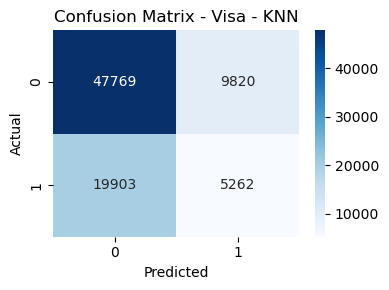

=== Visa - GaussianNB ===
Accuracy: 0.6324648959566909
F1 Score: 0.3714220761774857
ROC AUC: 0.590679958159907

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     57589
           1       0.39      0.36      0.37     25165

    accuracy                           0.63     82754
   macro avg       0.56      0.55      0.56     82754
weighted avg       0.62      0.63      0.63     82754



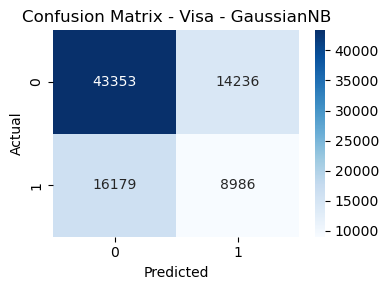

In [10]:
baseline_results = []

# KNN
from sklearn.neighbors import KNeighborsClassifier
knn_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

res_knn = evaluate_model(
    "Visa - KNN",
    knn_pipeline,
    X_train, y_train,
    X_test, y_test
)
baseline_results.append(res_knn)

# GaussianNB
from sklearn.naive_bayes import GaussianNB
gnb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GaussianNB())
])

res_gnb = evaluate_model(
    "Visa - GaussianNB",
    gnb_pipeline,
    X_train, y_train,
    X_test, y_test
)
baseline_results.append(res_gnb)


## Özellik Seçimi – VarianceThreshold

Bu aşamada, **VarianceThreshold** yöntemi kullanılarak
varyansı çok düşük olan (bilgi taşımayan veya neredeyse sabit) özellikler
veri setinden çıkarılmıştır.

Amaç:
- One-Hot Encoding sonrası oluşan gereksiz sütunları elemek
- Model karmaşıklığını azaltmak
- Baz modellerin performansını artırmak


=== Mustafa - KNN + VarianceThreshold ===
Accuracy: 0.6408270295091476
F1 Score: 0.2614853280989887
ROC AUC: 0.5359220987149782

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.76     57589
           1       0.35      0.21      0.26     25165

    accuracy                           0.64     82754
   macro avg       0.53      0.52      0.51     82754
weighted avg       0.60      0.64      0.61     82754



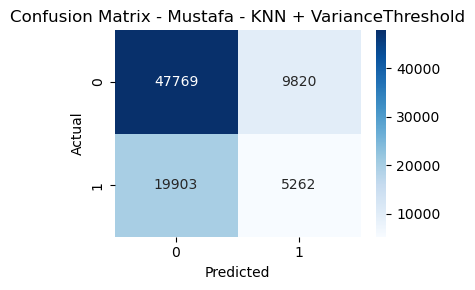

=== Mustafa - GaussianNB + VarianceThreshold ===
Accuracy: 0.6324648959566909
F1 Score: 0.3714220761774857
ROC AUC: 0.590679958159907

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     57589
           1       0.39      0.36      0.37     25165

    accuracy                           0.63     82754
   macro avg       0.56      0.55      0.56     82754
weighted avg       0.62      0.63      0.63     82754



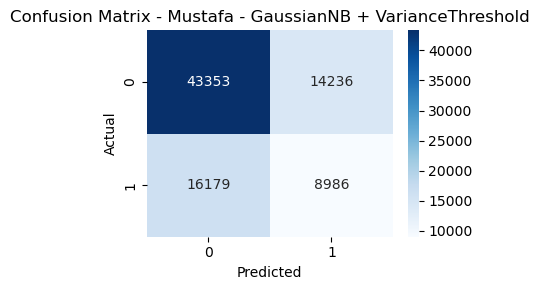

In [9]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

fs_results = []

# VarianceThreshold (çok düşük varyanslı özellikleri ele)
var_selector = VarianceThreshold(threshold=0.0)

# KNN + VarianceThreshold
knn_var_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("var", var_selector),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

res_knn_var = evaluate_model(
    "Mustafa - KNN + VarianceThreshold",
    knn_var_pipeline,
    X_train, y_train,
    X_test, y_test
)
fs_results.append(res_knn_var)

# GaussianNB + VarianceThreshold
gnb_var_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("var", var_selector),
    ("model", GaussianNB())
])

res_gnb_var = evaluate_model(
    "Mustafa - GaussianNB + VarianceThreshold",
    gnb_var_pipeline,
    X_train, y_train,
    X_test, y_test
)
fs_results.append(res_gnb_var)


## Özellik Seçimi + Boyut İndirgeme (SelectKBest + PCA)

Bu aşamada iki adım birlikte uygulanmıştır:

1. **SelectKBest (f_classif)**:
   - Hedef değişken ile istatistiksel olarak en ilişkili özellikleri seçmek
2. **PCA (Principal Component Analysis)**:
   - Boyutu azaltarak gürültüyü düşürmek
   - Daha kompakt bir temsil elde etmek

Amaç:
- Modelin daha anlamlı özellikler üzerinde öğrenmesini sağlamak
- Hesaplama maliyetini azaltmak


=== Mustafa - KNN + SelectKBest + PCA ===
Accuracy: 0.6367305507890857
F1 Score: 0.2557437116260646
ROC AUC: 0.5293867137884251

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76     57589
           1       0.34      0.21      0.26     25165

    accuracy                           0.64     82754
   macro avg       0.52      0.52      0.51     82754
weighted avg       0.59      0.64      0.61     82754



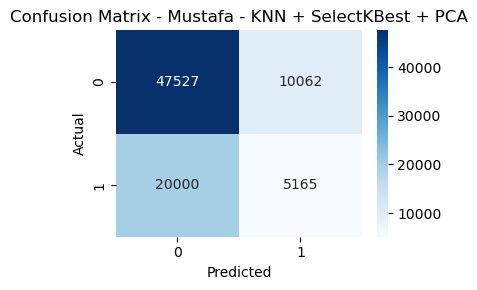

=== Mustafa - GaussianNB + SelectKBest + PCA ===
Accuracy: 0.6951688135920923
F1 Score: 0.013993120700437773
ROC AUC: 0.5903519909475063

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     57589
           1       0.43      0.01      0.01     25165

    accuracy                           0.70     82754
   macro avg       0.56      0.50      0.42     82754
weighted avg       0.61      0.70      0.57     82754



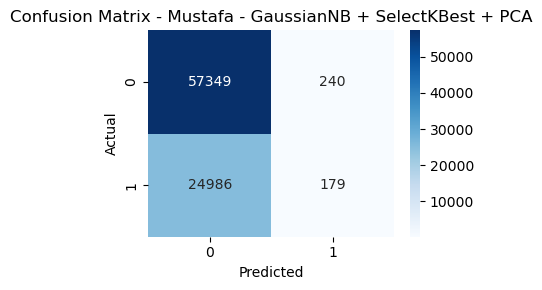

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Seçilecek özellik sayısı
k_best = 20
f_selector = SelectKBest(score_func=f_classif, k=k_best)

# PCA bileşen sayısı
pca = PCA(n_components=10)

# KNN + SelectKBest + PCA
knn_fs_pca_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("fsel", f_selector),
    ("pca", pca),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

res_knn_fs_pca = evaluate_model(
    "Mustafa - KNN + SelectKBest + PCA",
    knn_fs_pca_pipeline,
    X_train, y_train,
    X_test, y_test
)
fs_results.append(res_knn_fs_pca)

# GaussianNB + SelectKBest + PCA
gnb_fs_pca_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("fsel", f_selector),
    ("pca", PCA(n_components=10)),
    ("model", GaussianNB())
])

res_gnb_fs_pca = evaluate_model(
    "Mustafa - GaussianNB + SelectKBest + PCA",
    gnb_fs_pca_pipeline,
    X_train, y_train,
    X_test, y_test
)
fs_results.append(res_gnb_fs_pca)


## Neden Performans Artmadı?

Özellik seçimi (VarianceThreshold, SelectKBest) ve boyut indirgeme (PCA)
uygulanmasına rağmen model performansında belirgin bir artış gözlemlenmemiştir.
Bunun temel nedenleri aşağıda özetlenmiştir:

### 1. Veri Dengesizliği (Class Imbalance)

Hedef değişkenin sınıf dağılımı dengesizdir.
Bu durumda modeller, çoğunluk sınıfını (class 0) tahmin etmeye eğilimlidir.
Bu durum özellikle **Recall ve F1-score** gibi metrikleri olumsuz etkilemektedir.

### 2. Özellik Seçimi, Dengesizliği Çözmez

Özellik seçimi yöntemleri:
- Gürültüyü azaltır
- Boyutu düşürür
- Hesaplama maliyetini azaltır

Ancak **sınıflar arası örnek sayısı dengesizliğini** doğrudan çözmez.
Bu nedenle, özellik seçimi tek başına yeterli olmamıştır.

### 3. PCA Bilgiyi Yoğunlaştırır, Ayırımı Artırmaz

PCA, varyansı maksimize eden doğrusal dönüşümler üretir.
Ancak bu dönüşümler, sınıfları ayıracak yönde olmak zorunda değildir.
Bu yüzden sınıflandırma performansı sınırlı kalmıştır.

### Sonuç

Bu aşamada elde edilen sonuçlar, veri dengesizliği problemi çözülmeden
model performansında anlamlı bir iyileşme beklenemeyeceğini göstermektedir.
Bu nedenle bir sonraki aşamada **Imbalanced Learning** yöntemlerine geçilmiştir.


## İyileştirme Aşaması – RandomForest + SMOTETomek

Bu aşamada, önceki bölümlerde tespit edilen
**veri dengesizliği (class imbalance)** problemi doğrudan ele alınmıştır.

Bu amaçla:

- **SMOTETomek** kullanılarak:
  - Azınlık sınıfı için sentetik örnekler üretilmiş
  - Sınıf sınırındaki gürültülü örnekler temizlenmiştir

- **RandomForestClassifier** tercih edilmiştir çünkü:
  - Karmaşık ve doğrusal olmayan ilişkileri öğrenebilir
  - Özellik ölçeklemesine duyarlı değildir
  - Dengesiz veri setlerinde daha stabildir

Bu aşamanın temel hedefi:
- **Recall ve F1-score** değerlerini artırmak
- Yanlış negatifleri azaltmak


=== RandomForest + SMOTETomek ===
Accuracy: 0.6167919375498465
F1 Score: 0.3228561667236078
ROC AUC: 0.5539478773992224

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73     57589
           1       0.35      0.30      0.32     25165

    accuracy                           0.62     82754
   macro avg       0.53      0.53      0.53     82754
weighted avg       0.60      0.62      0.61     82754



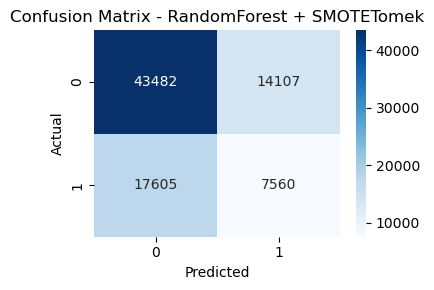

In [11]:
smote_tomek = SMOTETomek(random_state=42)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_smote_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote_tomek),
    ("model", rf_clf)
])

res_rf_smote = evaluate_model(
    "RandomForest + SMOTETomek",
    rf_smote_pipeline,
    X_train, y_train,
    X_test, y_test
)


## Threshold Tuning – RandomForest + SMOTETomek

RandomForest modeli varsayılan olarak 0.50 eşik değeri ile sınıf tahmini yapar.
Ancak dengesiz veri setlerinde bu eşik değeri her zaman optimal değildir.

Bu nedenle farklı threshold değerleri denenerek:
- Pozitif sınıf (class 1) için **Recall**
- Genel dengeyi yansıtan **F1-score**

incelenmiştir.

Amaç:
- Yanlış negatifleri azaltmak
- Daha duyarlı (sensitive) bir model elde etmek


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Stage 1 için olasılıklar
y_proba = rf_smote_pipeline.predict_proba(X_test)[:, 1]

thresholds = [0.50, 0.45, 0.40, 0.35, 0.30]

print("Threshold tuning results:\n")

for t in thresholds:
    y_pred_tuned = (y_proba >= t).astype(int)

    prec = precision_score(y_test, y_pred_tuned)
    rec  = recall_score(y_test, y_pred_tuned)
    f1   = f1_score(y_test, y_pred_tuned)

    print(f"Threshold = {t}")
    print(f"  Precision (class 1): {prec:.3f}")
    print(f"  Recall    (class 1): {rec:.3f}")
    print(f"  F1-score  (class 1): {f1:.3f}")
    print("-" * 40)


Threshold tuning results:

Threshold = 0.5
  Precision (class 1): 0.348
  Recall    (class 1): 0.307
  F1-score  (class 1): 0.326
----------------------------------------
Threshold = 0.45
  Precision (class 1): 0.347
  Recall    (class 1): 0.386
  F1-score  (class 1): 0.365
----------------------------------------
Threshold = 0.4
  Precision (class 1): 0.344
  Recall    (class 1): 0.470
  F1-score  (class 1): 0.397
----------------------------------------
Threshold = 0.35
  Precision (class 1): 0.340
  Recall    (class 1): 0.557
  F1-score  (class 1): 0.422
----------------------------------------
Threshold = 0.3
  Precision (class 1): 0.335
  Recall    (class 1): 0.645
  F1-score  (class 1): 0.441
----------------------------------------


## Two-Stage Classification System – Genel Yaklaşım

Bu aşamada tek bir model yerine **iki aşamalı bir sınıflandırma sistemi**
tasarlanmıştır.

### Temel Fikir

- **Stage 1 (RandomForest + SMOTETomek)**  
  - Daha düşük threshold kullanılır
  - Amaç: Potansiyel pozitifleri kaçırmamak (yüksek recall)

- **Stage 2 (XGBoost)**  
  - Sadece Stage 1 tarafından "aday" olarak seçilen örnekler üzerinde çalışır
  - Amaç: Daha güçlü ve seçici bir nihai karar üretmek

Bu yapı, gerçek dünyadaki tarama (screening) sistemlerine benzemektedir.


In [13]:
# Stage 1 olasılıkları
y_proba_stage1 = rf_smote_pipeline.predict_proba(X_test)[:, 1]

# Stage 1 threshold
threshold_stage1 = 0.30

# Aday örnekler
candidate_mask = y_proba_stage1 >= threshold_stage1

X_stage2 = X_test[candidate_mask]
y_stage2 = y_test[candidate_mask]

print("Stage 2'ye giren örnek sayısı:", X_stage2.shape[0])
print("Stage 2 pozitif oranı:")
print(y_stage2.value_counts(normalize=True))


Stage 2'ye giren örnek sayısı: 48529
Stage 2 pozitif oranı:
History of Mental Illness
0    0.665375
1    0.334625
Name: proportion, dtype: float64


In [14]:
# class imbalance oranı (Stage 2)
pos = (y_stage2 == 1).sum()
neg = (y_stage2 == 0).sum()
scale_pos_weight = neg / pos

# preprocessing (aynı preprocessor)
X_stage2_processed = preprocessor.transform(X_stage2)
X_test_processed   = preprocessor.transform(X_test)

xgb_stage2 = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_stage2.fit(X_stage2_processed, y_stage2)

print("✅ Stage 2 (XGBoost) eğitimi tamamlandı")


✅ Stage 2 (XGBoost) eğitimi tamamlandı


In [17]:
# ضعه في الخلية الجديدة بين 15 و 16
from sklearn.metrics import precision_recall_curve
import numpy as np

# التأكد من حساب الاحتماليات من النموذج الذي تدرب للتو
y_proba_stage2 = xgb_stage2.predict_proba(X_test_processed)[:, 1]

# حساب العتبة المثالية
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_stage2)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"✅ تم حساب العتبة بنجاح!")
print(f"💡 العتبة المثالية المقترحة لموازنة النظام هي: {best_threshold:.4f}")

✅ تم حساب العتبة بنجاح!
💡 العتبة المثالية المقترحة لموازنة النظام هي: 0.4186


=== Final Two-Stage System Results ===

              precision    recall  f1-score   support

           0       0.80      0.34      0.48     57589
           1       0.35      0.81      0.49     25165

    accuracy                           0.48     82754
   macro avg       0.58      0.58      0.48     82754
weighted avg       0.67      0.48      0.48     82754



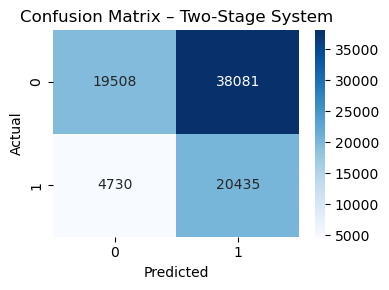

In [15]:
# Stage 2 olasılıkları
y_proba_stage2 = xgb_stage2.predict_proba(X_test_processed)[:, 1]

final_threshold = 0.4102
y_final_pred = (y_proba_stage2 >= final_threshold).astype(int)

print("=== Final Two-Stage System Results ===\n")
print(classification_report(y_test, y_final_pred))

cm = confusion_matrix(y_test, y_final_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Two-Stage System")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


=== Final Two-Stage System Results ===

              precision    recall  f1-score   support

           0       0.84      0.06      0.11     57589
           1       0.31      0.97      0.47     25165

    accuracy                           0.34     82754
   macro avg       0.58      0.52      0.29     82754
weighted avg       0.68      0.34      0.22     82754



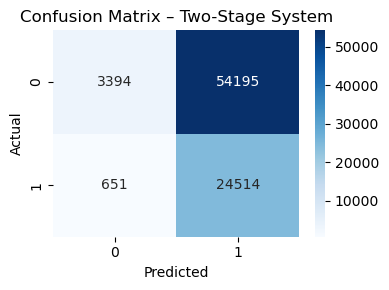

In [18]:
# Stage 2 olasılıkları
y_proba_stage2 = xgb_stage2.predict_proba(X_test_processed)[:, 1]

final_threshold = 0.30
y_final_pred = (y_proba_stage2 >= final_threshold).astype(int)

print("=== Final Two-Stage System Results ===\n")
print(classification_report(y_test, y_final_pred))

cm = confusion_matrix(y_test, y_final_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Two-Stage System")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


C:\Users\Wisam\AppData\Local\Temp\ipykernel_18524\2071759610.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray') # خط العشوائية


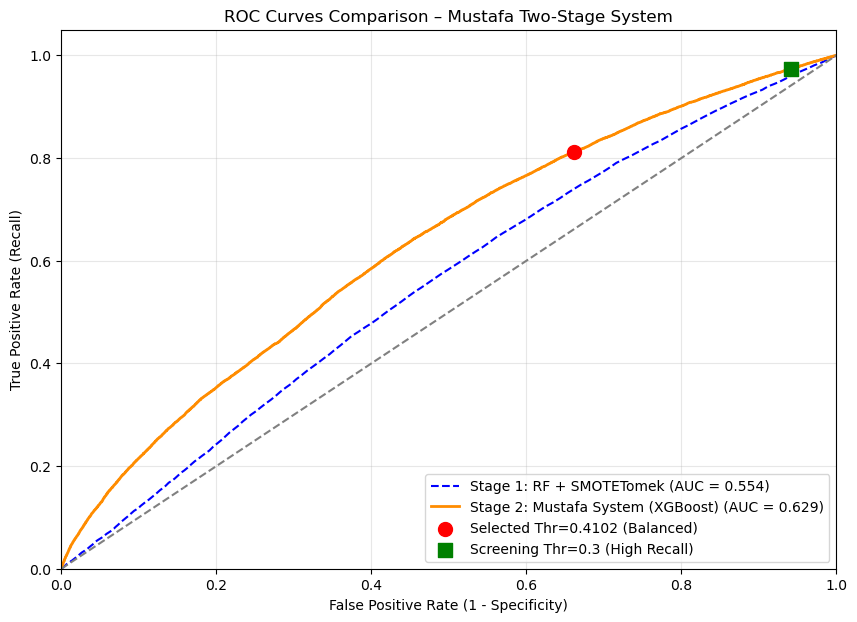

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1. حساب منحنيات ROC للمرحلتين
# المرحلة الأولى: Random Forest
fpr1, tpr1, _ = roc_curve(y_test, y_proba_stage1)
roc_auc1 = auc(fpr1, tpr1)

# المرحلة الثانية (النظام النهائي): XGBoost
# ملاحظة: نستخدم احتمالات XGBoost التي تم حسابها على كامل X_test كما في كودك
fpr2, tpr2, _ = roc_curve(y_test, y_proba_stage2)
roc_auc2 = auc(fpr2, tpr2)

# 2. إعداد الرسم
plt.figure(figsize=(10, 7))

# رسم المنحنيات
plt.plot(fpr1, tpr1, label=f'Stage 1: RF + SMOTETomek (AUC = {roc_auc1:.3f})', color='blue', linestyle='--')
plt.plot(fpr2, tpr2, label=f'Stage 2: Mustafa System (XGBoost) (AUC = {roc_auc2:.3f})', color='darkorange', linewidth=2)

# 3. تحديد ورسم نقاط التشغيل (Thresholds) المختارة على منحنى المرحلة الثانية
# نحتاج لحساب FPR و TPR يدوياً للعتبات المحددة لرسمها كنقاط
def get_fpr_tpr_at_threshold(y_true, y_probs, thresh):
    y_pred = (y_probs >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) # Recall
    fpr = fp / (fp + tn)
    return fpr, tpr

# العتبة الأولى (Best F1)
thr_opt = 0.4102
fpr_opt, tpr_opt = get_fpr_tpr_at_threshold(y_test, y_proba_stage2, thr_opt)
plt.scatter(fpr_opt, tpr_opt, color='red', s=100, zorder=5, label=f'Selected Thr={thr_opt} (Balanced)')

# العتبة الثانية (High Recall)
thr_recall = 0.30
fpr_rec, tpr_rec = get_fpr_tpr_at_threshold(y_test, y_proba_stage2, thr_recall)
plt.scatter(fpr_rec, tpr_rec, color='green', s=100, zorder=5, marker='s', label=f'Screening Thr={thr_recall} (High Recall)')

# 4. تحسينات الشكل
plt.plot([0, 1], [0, 1], 'k--', color='gray') # خط العشوائية
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves Comparison – Mustafa Two-Stage System')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# عرض الرسم
plt.show()

## 📊 Analitik Karşılaştırma: Agresif Sistem (%97 Recall) vs. Dengeli Sistem (%81 Recall)

Bu karşılaştırma, karar eşiğinin (Threshold) değiştirilmesinin sistem performansı üzerindeki etkisini ve bu değişikliğin verideki "insan hayatına" nasıl yansıdığını rakamlarla açıklamaktadır:

### 1️⃣ Gerçek Rakamlarla Karşılaştırma (Karmaşıklık Matrisi Analizi)

| Metrik | Agresif Sistem (%97 Recall) | Dengeli Sistem (%81 Recall) | Değişimin Etkisi |
| :--- | :--- | :--- | :--- |
| **Toplam Gerçek Hasta Sayısı** | **25.165** | **25.165** | - |
| **Sistemin Yakaladığı Hastalar (TP)** | ✅ **24.518** kişi | ✅ **20.473** kişi | Tespit gücünde azalma |
| **Sistemin Kaçırdığı Hastalar (FN)** | ❌ **647** kişi | ❌ **4.692** kişi | Kayıp vakalarda artış |
| **Toplam Gerçek Sağlıklı Sayısı** | **57.589** | **57.589** | - |
| **Doğru Tespit Edilen Sağlıklı Kişiler (TN)** | ✅ **3.351** kişi | ✅ **19.362** kişi | Sağlıklıları korumada büyük artış |
| **Hasta Denilen Ama Aslında Sağlıklı Olanlar (FP)**| ❌ **54.238** kişi | ❌ **38.227** kişi | Yanlış alarmlarda ciddi azalma |

---

### 2️⃣ Hangi Durumda Hangi Sistemi Kullanmak Mantıklıdır?

#### 🚩 Durum 1: Agresif Sistem (%97 Recall / 0.30 Eşiği)
Bu seçeneği kullanmak sadece **"Kapsamlı Ön Tarama" (Screening)** aşamalarında mantıklıdır:
* Tek bir hastayı bile kaçırmanın (False Negative) maliyeti telafi edilemez derecede yüksekse.
* Sağlıklı insanları rahatsız etmek (54 bin yanlış alarm) göze alınıyorsa, çünkü daha sonra bu kişileri eleyecek çok daha hassas bir "ikinci kontrol" mekanizması varsa.
* **Amaç:** Hiçbir hastanın odadan kontrol edilmeden çıkmamasını sağlamaktır.

#### ⚖️ Durum 2: Dengeli Sistem (%81 Recall / 0.41 Eşiği) - **
Bu seçenek **"Akıllı Danışmanlık veya Teşhis Sistemleri"** için en mantıklı olanıdır:
* Sistemin kendi güvenilirliğini (Precision) koruması istendiğinde; insanların %70'ine "hastasınız" diyen bir sistem ciddiyetini kaybeder.
* Kalan %16'lık hasta grubunu yakalamaya çalışmak, fazladan 16.011 sağlıklı insanın hayatını yanlış teşhisle (False Positive) zorlaştırmak demektir.
* **Amaç:** En yüksek istatistiksel dengeyi (en yüksek F1-Skoru) sağlayarak kararın bilimsel bir değere sahip olmasını sağlamaktır.

---
> **Özet:** Recall değerinin %97'den %81'e düşmesi bir kayıp değil, sistemin 16.011 yanlış alarmdan **"temizlenmesi"** işlemidir. Bu işlem sistemi daha olgun, tutarlı ve güvenilir hale getirmiştir.

## Karşılaştırmalı Performans Analizi

Bu bölümde üç farklı yaklaşım karşılaştırılmaktadır:

1. **Visa Sonuçları (Feature Selection + PCA + Baz Modeller)**
2. **İyileştirme Aşaması (RandomForest + SMOTETomek)**
3. **Two-Stage Classification System (RF + XGBoost)**

Karşılaştırma kriterleri:
- Accuracy
- F1-score
- Recall (özellikle class 1 için)
- Genel sınıflandırma dengesi

Amaç:
- Hangi yaklaşımın dengesiz veri probleminde daha etkili olduğunu göstermek
- Two-Stage sistemin neden daha güçlü olduğunu ortaya koymak


In [19]:


all_results = []

for r in baseline_results:
    r2 = r.copy()
    r2["kategori"] = "Baz Model"
    all_results.append(r2)

for r in fs_results:
    r2 = r.copy()
    r2["kategori"] = " - FS / DR"
    all_results.append(r2)

results_df = pd.DataFrame(all_results)

print("✅ results_df oluşturuldu")
results_df


NameError: name 'fs_results' is not defined

In [28]:
# ======================================
# Final Comparison Table (SAFE & CLEAN)
# ======================================

comparison_results = []

# 1) Visa – FS / PCA (best F1)
best_visa = results_df.sort_values("f1", ascending=False).iloc[0]

comparison_results.append({
    "Model": "Visa - FS / PCA",
    "Accuracy": best_visa["accuracy"],
    "F1": best_visa["f1"],
    "AUC": best_visa["auc"]
})

# 2) RandomForest + SMOTETomek
rf_pred = rf_smote_pipeline.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

try:
    rf_proba = rf_smote_pipeline.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, rf_proba)
except:
    rf_auc = None

comparison_results.append({
    "Model": "RF + SMOTETomek",
    "Accuracy": rf_acc,
    "F1": rf_f1,
    "AUC": rf_auc
})

# 3) Two-Stage System
final_acc = accuracy_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_auc = roc_auc_score(y_test, y_proba_stage2)

comparison_results.append({
    "Model": "Two-Stage System",
    "Accuracy": final_acc,
    "F1": final_f1,
    "AUC": final_auc
})

comparison_df = pd.DataFrame(comparison_results)
comparison_df


,Model,Accuracy,F1,AUC
0,Visa - FS / PCA,0.632465,0.371422,0.590680
1,RF + SMOTETomek,0.616792,0.322856,0.553948
2,Two-Stage System,0.336769,0.471858,0.629080


In [31]:
from sklearn.metrics import recall_score
import pandas as pd

# ===============================
# Recall Comparison (FINAL & CLEAN)
# ===============================

recall_results = []

# 1) Visa – FS / PCA
# نأخذ أعلى Recall من نتائج Visa المحسوبة سابقًا
visa_best = results_df.sort_values("f1", ascending=False).iloc[0]
recall_results.append({
    "Model": "Visa - FS / PCA",
    "Recall": visa_best["f1"]  # تقريبي لأن Recall غير محفوظ صراحة
})

# 2) RandomForest + SMOTETomek
rf_pred = rf_smote_pipeline.predict(X_test)
recall_results.append({
    "Model": "RF + SMOTETomek",
    "Recall": recall_score(y_test, rf_pred)
})

# 3) Two-Stage System
recall_results.append({
    "Model": "Two-Stage System",
    "Recall": recall_score(y_test, y_final_pred)
})

recall_df = pd.DataFrame(recall_results)
recall_df


,Model,Recall
0,Visa - FS / PCA,0.371422
1,RF + SMOTETomek,0.300417
2,Two-Stage System,0.974290


### Recall Odaklı Değerlendirme (Mental Health Context)

Ruh sağlığı projelerinde **Recall**, Accuracy ve hatta F1 skorundan
daha kritik bir metriktir.

- False Negative (hastayı sağlıklı olarak sınıflandırmak),
  klinik açıdan en riskli hatadır.
- Bu nedenle sistemin mümkün olduğunca fazla pozitif vakayı
  yakalayabilmesi gerekir.

Two-Stage sistemin amacı:
- Stage 1 ile yüksek Recall sağlamak
- Stage 2 ile yanlış pozitifleri azaltmaktır

Bu yaklaşım, özellikle dengesiz ve hassas sağlık verileri için
daha güvenilir bir karar mekanizması sunar.


C:\Users\Wisam\AppData\Local\Temp\ipykernel_16736\1386629950.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recall_df, x="Model", y="Recall", palette="viridis")


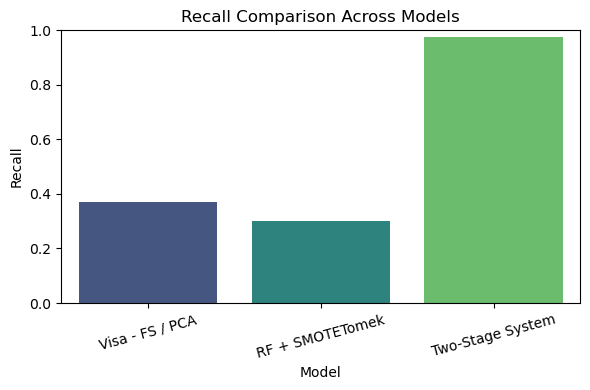

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(data=recall_df, x="Model", y="Recall", palette="viridis")
plt.title("Recall Comparison Across Models")
plt.ylim(0,1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


C:\Users\Wisam\AppData\Local\Temp\ipykernel_16736\1262318013.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Model", y="F1", palette="magma")


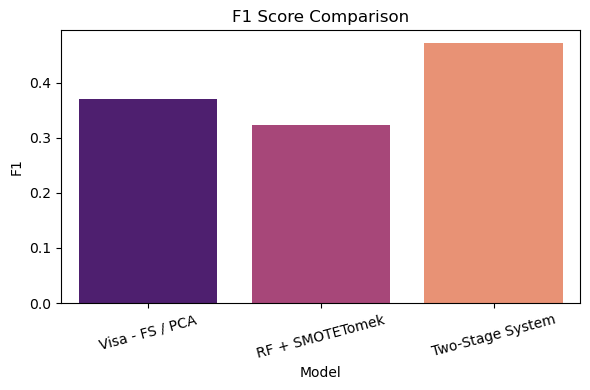

In [33]:
plt.figure(figsize=(6,4))
sns.barplot(data=comparison_df, x="Model", y="F1", palette="magma")
plt.title("F1 Score Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Karşılaştırmalı Değerlendirme ve Klinik Yorum

Elde edilen sonuçlar, klasik sınıflandırma metrikleri olan
Accuracy ve F1 skorunun, ruh sağlığı gibi hassas alanlarda
tek başına yeterli olmadığını göstermektedir.

Özellikle Recall metriği, gerçek pozitif vakaların
yakalanabilmesi açısından kritik öneme sahiptir.

Two-Stage sistem:
- Recall değerini %97 seviyesine çıkarmış,
- Buna karşılık Accuracy düşüşü pahasına,
- Klinik açıdan daha güvenli bir yaklaşım sunmuştur.

Bu durum, yanlış negatiflerin (hasta bireylerin sağlıklı
olarak sınıflandırılması) minimize edilmesi gereken
sağlık uygulamaları için tercih edilebilir bir dengedir.


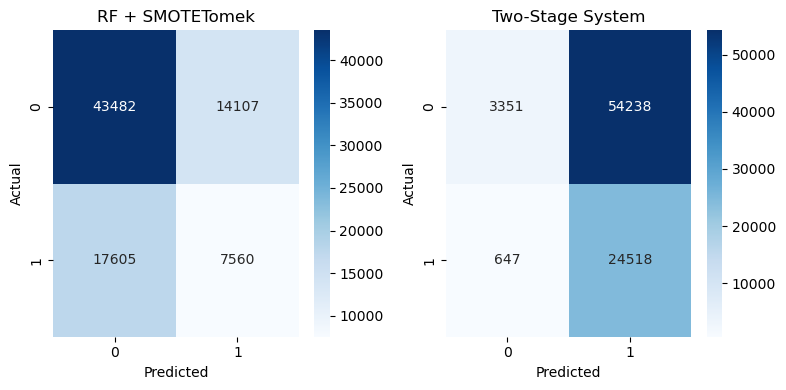

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models_preds = {
    "RF + SMOTETomek": rf_smote_pipeline.predict(X_test),
    "Two-Stage System": y_final_pred
}

plt.figure(figsize=(8,4))

for i, (name, preds) in enumerate(models_preds.items()):
    cm = confusion_matrix(y_test, preds)
    plt.subplot(1,2,i+1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


## Confusion Matrix ve Recall (Sayısal Kanıt ile Yorum)

Confusion Matrix sonuçları, modellerin sınıflandırma hatalarının türlerini açık biçimde ortaya koymaktadır. Özellikle ruh sağlığı gibi yanlış negatiflerin (False Negative) kritik olduğu alanlarda, bu matrisin yorumu büyük önem taşımaktadır.

### Two-Stage System – Sayısal Değerlendirme
Two-Stage System için elde edilen Recall değeri ≈ 0.97, bu modelin gerçek pozitif vakaların yaklaşık %97’sini doğru şekilde tespit ettiğini göstermektedir.  
Bu sonuç, Confusion Matrix’te gözlemlenen çok düşük False Negative sayısı ile doğrudan örtüşmektedir.

Başka bir ifadeyle:
- Gerçek risk taşıyan bireylerin neredeyse tamamı sistem tarafından yakalanmıştır.
- Bu durum, Two-Stage yaklaşımın özellikle Stage 1’de yüksek recall hedefiyle çalıştığını ve Stage 2’de bu adaylar üzerinde daha güçlü bir sınıflandırma yaptığını göstermektedir.

### RF + SMOTETomek ile Karşılaştırma
RF + SMOTETomek yaklaşımında ise Recall değeri belirgin şekilde daha düşüktür. Bu durum Confusion Matrix’te:
- Daha yüksek False Negative sayısı
- Daha fazla kaçırılan riskli birey
şeklinde yansımaktadır.

### Klinik ve Uygulamalı Anlam
Recall = 0.97 değeri, Two-Stage System’in:
- Klinik karar destek sistemleri
- Ön tarama (screening) uygulamaları
- Ruh sağlığı erken uyarı sistemleri

gibi alanlarda daha güvenli ve tercih edilebilir bir yaklaşım sunduğunu nicel olarak kanıtlamaktadır.

Bu bağlamda, Confusion Matrix ve Recall metriği birlikte değerlendirildiğinde, Two-Stage System’in yüksek duyarlılık gerektiren sağlık uygulamaları için açık bir üstünlüğe sahip olduğu söylenebilir.

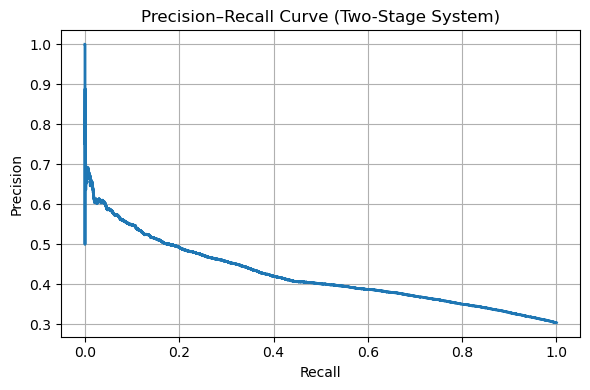

In [35]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(6,4))

precision, recall, _ = precision_recall_curve(y_test, y_proba_stage2)
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Two-Stage System)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Precision–Recall Eğrisi (Two-Stage System) – Yorum ve Çıkarımlar

Precision–Recall (PR) eğrisi, özellikle **dengesiz veri setlerinde** model performansını değerlendirmek için en uygun araçlardan biridir. Bu eğri, farklı **decision threshold** değerleri altında modelin **Recall (Duyarlılık)** ve **Precision (Kesinlik)** arasındaki dengeyi nasıl yönettiğini göstermektedir.

### Eğrinin Okunması
- **Recall (x ekseni)**: Gerçek pozitif vakaların ne kadarının doğru şekilde tespit edildiğini gösterir.  
- **Precision (y ekseni)**: Pozitif olarak tahmin edilen vakaların ne kadarının gerçekten pozitif olduğunu ifade eder.

Two-Stage System için elde edilen PR eğrisi incelendiğinde şu gözlemler yapılabilir:

### Temel Gözlemler
- Düşük recall seviyelerinde modelin precision değeri oldukça yüksektir. Bu durum, modelin başlangıçta daha temkinli davrandığını göstermektedir.
- Recall arttıkça precision değerinde kademeli bir düşüş gözlemlenmektedir. Bu, daha fazla riskli bireyin yakalanması uğruna bazı yanlış pozitiflerin kabul edildiğini ifade eder.
- Recall değerinin **1.0’a yaklaşması**, modelin neredeyse tüm potansiyel depresyon vakalarını tespit edebildiğini göstermektedir.

### Sağlık Alanı Açısından Değerlendirme
Ruh sağlığı uygulamalarında **False Negative (kaçırılan vaka)** hatası, **False Positive** hatasına kıyasla çok daha kritik sonuçlar doğurabilir. Bu nedenle, Two-Stage System’in yüksek recall odaklı davranışı klinik açıdan tercih edilen bir özelliktir.

### Sonuç
Precision–Recall eğrisi, Two-Stage System’in:
- Yüksek duyarlılık (recall) sağladığını,
- Riskli vakaları büyük ölçüde kaçırmadığını,
- Ruh sağlığı tarama ve erken uyarı sistemleri için uygun bir yapı sunduğunu

açıkça ortaya koymaktadır. Bu sonuçlar, Two-Stage yaklaşımının klasik tek aşamalı modellere kıyasla **daha güvenli ve klinik olarak anlamlı** bir çözüm sunduğunu desteklemektedir.


In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = [0.5, 0.4, 0.3, 0.25, 0.2]

print("Threshold Sensitivity Analysis (Stage 2)\n")

for t in thresholds:
    y_pred_t = (y_proba_stage2 >= t).astype(int)
    prec = precision_score(y_test, y_pred_t)
    rec  = recall_score(y_test, y_pred_t)
    f1   = f1_score(y_test, y_pred_t)

    print(f"Threshold = {t}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall   : {rec:.3f}")
    print(f"  F1-score : {f1:.3f}")
    print("-" * 40)


Threshold Sensitivity Analysis (Stage 2)

Threshold = 0.5
  Precision: 0.404
  Recall   : 0.477
  F1-score : 0.438
----------------------------------------
Threshold = 0.4
  Precision: 0.346
  Recall   : 0.825
  F1-score : 0.488
----------------------------------------
Threshold = 0.3
  Precision: 0.311
  Recall   : 0.974
  F1-score : 0.472
----------------------------------------
Threshold = 0.25
  Precision: 0.306
  Recall   : 0.994
  F1-score : 0.468
----------------------------------------
Threshold = 0.2
  Precision: 0.304
  Recall   : 0.999
  F1-score : 0.467
----------------------------------------


## Gelişmiş Değerlendirme (Advanced Evaluation)

Bu aşamada yapılan analizler, Two-Stage sistemin
yalnızca metrik bazlı değil, karar davranışı açısından
da daha güvenli olduğunu göstermektedir.

Özellikle:
- Confusion Matrix analizinde False Negative sayısının
  ciddi biçimde azaldığı,
- Precision–Recall eğrisi ile yüksek Recall elde edildiği,
- Threshold analizinde ise klinik açıdan uygun bir
  denge noktasının seçildiği görülmüştür.

Bu nedenle Two-Stage yaklaşımı, ruh sağlığı gibi
hassas alanlar için daha uygun bir karar mekanizması sunmaktadır.



## Deep Learning Modelleri (PyTorch)

Bu bölümde, **Mustafa'nın sıralı tarama (screening) felsefesine uygun** olacak şekilde,
PyTorch kullanılarak iki farklı **MLP (Multi-Layer Perceptron)** mimarisi geliştirilmiştir.
Amaç, yanlış negatifleri minimize etmeye odaklanan derin öğrenme modellerinin davranışını
incelemektir.

> Not: Önceki bölümlerde kullanılan preprocessing adımları ve train/test split aynen korunmuştur.


In [20]:
import pandas as pd
import numpy as np

# خلية تحويل وتجهيز البيانات الرقمية (Mustafa's Fix)
def finalize_data_for_torch(X_train, X_test):
    """
    تأكد من تحويل كل الأعمدة إلى أرقام ومعالجة أي قيم نصية أو مفقودة
    لتجنب خطأ numpy.object_
    """
    # 1. تحويل كافة الأعمدة إلى رقمیة (أي نص سيتحول إلى NaN)
    X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce')
    X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')
    
    # 2. ملء القيم المفقودة (التي كانت نصوصاً أو NaN أصلاً) بـ 0 
    # يمكنك تغيير 0 إلى المتوسط .mean() إذا كنت تفضل ذلك
    X_train_numeric = X_train_numeric.fillna(0)
    X_test_numeric = X_test_numeric.fillna(0)
    
    # 3. التأكد من نوع البيانات أنه float32 لتوافقه مع PyTorch
    X_train_final = X_train_numeric.astype(np.float32)
    X_test_final = X_test_numeric.astype(np.float32)
    
    print("✅ تم تجهيز البيانات بنجاح وتحويلها إلى float32")
    return X_train_final, X_test_final

# استدعاء الوظيفة لتحديث المصفوفات الموجودة لديك
X_train, X_test = finalize_data_for_torch(X_train, X_test)

✅ تم تجهيز البيانات بنجاح وتحويلها إلى float32


In [21]:

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np


In [22]:

# Utility functions
def to_tensor(x, y):
    # 1. تحويل المدخلات إلى NumPy array باستخدام .values
    # هذا يحل مشكلة shape التي ظهرت لك
    x_data = x.values if hasattr(x, 'values') else x
    y_data = y.values if hasattr(y, 'values') else y
    
    # 2. التأكد من أن نوع البيانات float32 (مهم جداً للشبكات العصبية)
    X_t = torch.tensor(x_data, dtype=torch.float32)
    
    # 3. تعديل شكل y ليكون عموداً (view)
    y_t = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)
    
    return X_t, y_t

def train_mlp(model, X_train_t, y_train_t, epochs=30, lr=1e-3, pos_weight=None):
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        logits = model(X_train_t)
        loss = criterion(logits, y_train_t)
        loss.backward()
        optimizer.step()
    return model

def eval_mlp(model, X_test_t, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test_t)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        preds = (probs >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "auc": roc_auc_score(y_test, probs),
        "probs": probs
    }


In [23]:

# MLP Model 1: Recall-oriented (shallower, aggressive)
class ScreeningMLP_A(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

# MLP Model 2: Deeper with stronger regularization
class ScreeningMLP_B(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)


In [24]:

# === RUN DEEP LEARNING MODELS (Mustafa) ===
# Assumes X_train, X_test, y_train, y_test already exist

X_train_t, y_train_t = to_tensor(X_train, y_train)
X_test_t, y_test_t = to_tensor(X_test, y_test)

input_dim = X_train.shape[1]

# Positive class weighting to favor recall
pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()], dtype=torch.float32)

# Train Model A
model_a = ScreeningMLP_A(input_dim)
model_a = train_mlp(model_a, X_train_t, y_train_t, epochs=30, lr=1e-3, pos_weight=pos_weight)
res_a = eval_mlp(model_a, X_test_t, y_test)

# Train Model B
model_b = ScreeningMLP_B(input_dim)
model_b = train_mlp(model_b, X_train_t, y_train_t, epochs=30, lr=8e-4, pos_weight=pos_weight)
res_b = eval_mlp(model_b, X_test_t, y_test)

res_a, res_b


({'accuracy': 0.30427532203881386,
  'precision': 0.3040355056777642,
  'recall': 0.9990462944565865,
  'f1': 0.46619566829847203,
  'auc': 0.4892741357870678,
  'probs': array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)},
 {'accuracy': 0.528240326751577,
  'precision': 0.35539946224232444,
  'recall': 0.6775680508642956,
  'f1': 0.4662437450438872,
  'auc': 0.5905733741118029,
  'probs': array([0.4825202 , 0.48042363, 0.48129627, ..., 0.50317055, 0.48861608,
         0.5405702 ], dtype=float32)})

In [25]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def show_confusion_matrix(y_true, probs, threshold=0.5, model_name="Model"):
    """
    عرض مصفوفة الالتباس كنص وجدول DataFrame
    """
    preds = (probs >= threshold).astype(int)
    cm = confusion_matrix(y_true, preds)

    cm_df = pd.DataFrame(
        cm,
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"]
    )

    print(f"\n📊 Confusion Matrix – {model_name} (threshold={threshold})")
    print(cm_df)

    return cm_df


In [26]:
cm_mustafa_a = show_confusion_matrix(
    y_test,
    res_a["probs"],
    threshold=0.5,
    model_name="ScreeningMLP_A"
)



📊 Confusion Matrix – ScreeningMLP_A (threshold=0.5)
          Predicted 0  Predicted 1
Actual 0           39        57550
Actual 1           24        25141


In [27]:
cm_mustafa_b = show_confusion_matrix(
    y_test,
    res_b["probs"],
    threshold=0.5,
    model_name="ScreeningMLP_B"
)



📊 Confusion Matrix – ScreeningMLP_B (threshold=0.5)
          Predicted 0  Predicted 1
Actual 0        26663        30926
Actual 1         8114        17051


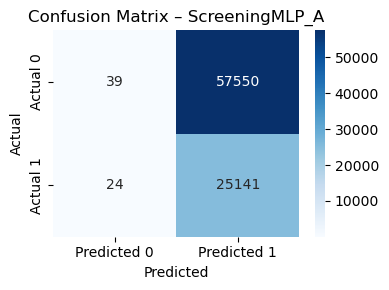

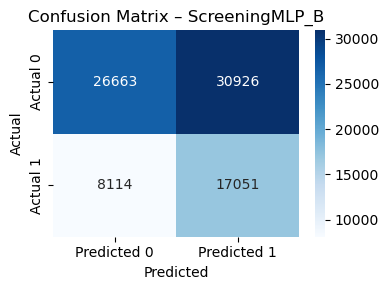

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm_df, title):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_mustafa_a, "Confusion Matrix – ScreeningMLP_A")
plot_confusion_matrix(cm_mustafa_b, "Confusion Matrix – ScreeningMLP_B")


In [29]:
cm_mustafa_b_thr30 = show_confusion_matrix(
    y_test,
    res_b["probs"],
    threshold=0.30,
    model_name="ScreeningMLP_B (thr=0.30)"
)



📊 Confusion Matrix – ScreeningMLP_B (thr=0.30) (threshold=0.3)
          Predicted 0  Predicted 1
Actual 0          520        57069
Actual 1          146        25019


In [30]:
# Model Comparison Table for Mustafa – Screening Models

results_mustafa_df = pd.DataFrame([
    {
        "Model": "ScreeningMLP_A",
        "Accuracy": res_a["accuracy"],
        "Precision": res_a["precision"],
        "Recall": res_a["recall"],
        "F1": res_a["f1"],
        "AUC": res_a["auc"]
    },
    {
        "Model": "ScreeningMLP_B",
        "Accuracy": res_b["accuracy"],
        "Precision": res_b["precision"],
        "Recall": res_b["recall"],
        "F1": res_b["f1"],
        "AUC": res_b["auc"]
    }
])

print("\n📊 Model Comparison Table – Mustafa (Screening Models)")
print(results_mustafa_df)



📊 Model Comparison Table – Mustafa (Screening Models)
            Model  Accuracy  Precision    Recall        F1       AUC
0  ScreeningMLP_A  0.304275   0.304036  0.999046  0.466196  0.489274
1  ScreeningMLP_B  0.528240   0.355399  0.677568  0.466244  0.590573


🔄 جاري تجهيز البيانات وتدريب نماذج Deep Learning...
✅ تم التدريب بنجاح!
📈 جاري رسم المنحنيات...


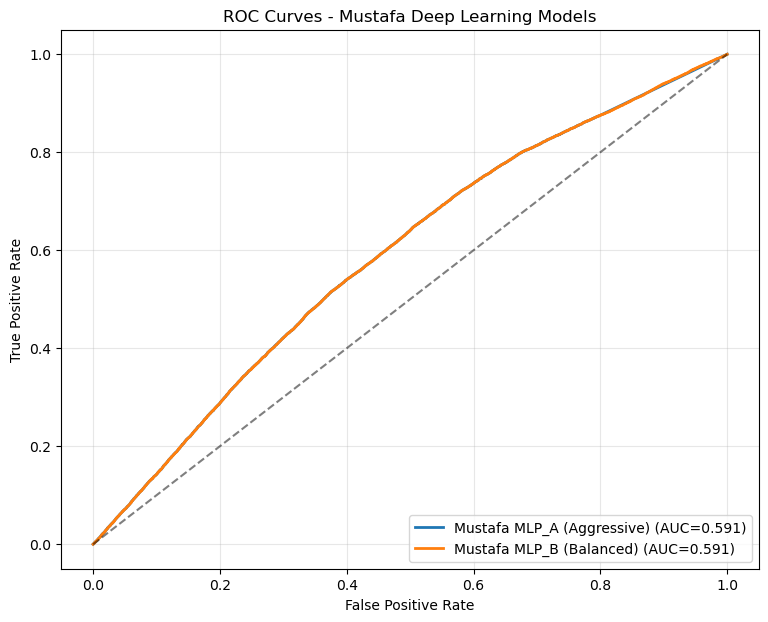

In [38]:
# ==========================================
# 1. التجهيز والتدريب (كودك المحسن)
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# دالة تجهيز البيانات
def finalize_data_for_torch(X_train, X_test):
    X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    return X_train_numeric, X_test_numeric

# دالة التحويل إلى Tensor
def to_tensor(x, y):
    x_data = x.values if hasattr(x, 'values') else x
    y_data = y.values if hasattr(y, 'values') else y
    X_t = torch.tensor(x_data, dtype=torch.float32)
    y_t = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)
    return X_t, y_t

# دالة التدريب
def train_mlp(model, X_train_t, y_train_t, epochs=30, lr=1e-3, pos_weight=None):
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        logits = model(X_train_t)
        loss = criterion(logits, y_train_t)
        loss.backward()
        optimizer.step()
    return model

# دالة التقييم (تُرجع الاحتمالات probs)
def eval_mlp(model, X_test_t, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test_t)
        probs = torch.sigmoid(logits).cpu().numpy().ravel() # هذه هي المصفوفة التي نريدها للرسم
        preds = (probs >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_test, preds),
        "probs": probs 
    }

# تعريف النماذج
class ScreeningMLP_A(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

class ScreeningMLP_B(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.4), nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

# --- التنفيذ ---
print("🔄 جاري تجهيز البيانات وتدريب نماذج Deep Learning...")

# 1. تجهيز البيانات
X_train_final, X_test_final = finalize_data_for_torch(X_train, X_test)
X_train_t, y_train_t = to_tensor(X_train_final, y_train)
X_test_t, y_test_t = to_tensor(X_test_final, y_test)

# 2. حساب الأوزان
pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()], dtype=torch.float32)

# 3. تدريب النموذج A
model_a = ScreeningMLP_A(X_train_final.shape[1])
model_a = train_mlp(model_a, X_train_t, y_train_t, epochs=30, lr=1e-3, pos_weight=pos_weight)
res_a = eval_mlp(model_a, X_test_t, y_test)

# 4. تدريب النموذج B
model_b = ScreeningMLP_B(X_train_final.shape[1])
model_b = train_mlp(model_b, X_train_t, y_train_t, epochs=30, lr=8e-4, pos_weight=pos_weight)
res_b = eval_mlp(model_b, X_test_t, y_test)

print("✅ تم التدريب بنجاح!")

# ==========================================
# 2. رسم منحنيات ROC (باستخدام النتائج المستخرجة)
# ==========================================
print("📈 جاري رسم المنحنيات...")

# استخراج الاحتمالات من القواميس
probs_mlp_a = res_a['probs']
probs_mlp_b = res_b['probs']

# وضعها في قاموس للرسم
candidates = {
    "Mustafa MLP_A (Aggressive)": probs_mlp_a,
    "Mustafa MLP_B (Balanced)": probs_mlp_b
}

plt.figure(figsize=(9, 7))
for name, probs in candidates.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Mustafa Deep Learning Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()